# The Battle of Neighborhoods

## Exploring Venues in Amritsar, India

## Table of Contents

- [Introduction](#Introduction)
- [Data Collection from APIs](#Data-Collection-from-APIs)
- [Foursquare API](#Foursquare-API)
- [Zomato API](#Zomato-API)
- [Data Cleaning](#Data-Cleaning)
- [Methodology](#Methodology)
- [Analysis](#Analysis)
- [Rating](#Rating)
- [Price](#Price)
- [Clustering](#Clustering)
- [Results](#Results)
- [Conclusion](#Conclusion)

<a id='Introduction'></a>
## Introduction

The aim of the project is to identify venues in __Amritsar, India__ based on their rating and average prices. In this notebook, we will identify various venues in Amritsar, India, using __Foursquare API and Zomato API__, to help visitors select the restaurants that suits them the most.

Whenever people visit a city they start looking for places to visit during their stay. There primarily look for places is based on the venue ratings across all venues and the average prices so that the location fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

<a id='Data-Collection-from-APIs'></a>
## Data Collection from APIs

To begin with, we will take a look at Amritsar on the Map using the folium library.

We will also fetch the data from two different APIs.

__Foursquare API:__ We will use the Foursquare API to fetch venues in Amritsar starting from the middle upto 20 Kilometers in each direction.

__Zomato API:__ The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

In [8]:
#-----Importing Libraries-------

import numpy as np           #library to handle data in a vectorized manner
import pandas as pd          #library for data analysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json                  #library to handle JSON files

from geopy.geocoders import Nominatim        #convert an address into latitude and longitude values

import requests             #library to handle requests
from pandas.io.json import json_normalize    #tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#import k-means from clustering stage
from sklearn.cluster import KMeans

import folium               #map rendering library

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Amritsar.

In order to define an instance of the geocoder, we need to define a user_agent.
We will name our agent <em>ny_explorer</em>, as shown below.

In [9]:
address = 'Amritsar, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
amr_latitude = location.latitude
amr_longitude = location.longitude
print('The geograpical coordinate of Amritsar are {}, {}.'.format(amr_latitude, amr_longitude))

The geograpical coordinate of Amritsar are 31.6343083, 74.8736788.


#### Let's use the folium library to create a complete map zoomed on Amritsar. We'll also plot a marker on the coordinates we just identified above.

In [10]:
amritsar_map = folium.Map(location = [amr_latitude, amr_longitude], zoom_start = 13)

label = '{}, {}'.format(amr_latitude, amr_longitude)
label = folium.Popup(label, parse_html=True)
folium.Marker([amr_latitude, amr_longitude] , label).add_to(amritsar_map)
amritsar_map.save("AmritsarMap//Amritsar Map.html")
amritsar_map

                 Zoom into the above map, and click on mark to reveal the latitude and longitude of Amritsar.

<a id='Foursquare-API'></a>
## Foursquare API
We begin by fetching a total of all venues in Jalandhar upto a range of 20 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

#### Define Foursquare Credentials and Version 

In [54]:
CLIENT_ID = 'your Foursquare ID'     # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = 'Foursquare API version'                                               # Foursquare API version

RADIUS = 20000 # 20 Km
NO_OF_VENUES = 100

We define the get_category_type method to get the correct category for each venue.

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
We will set the radius as 20 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [13]:
offset = 0
total_venues = 0
amritsar_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        amr_latitude, 
                                                                        amr_longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
result = requests.get(url).json()
venues_fetched = len(result['response']['groups'][0]['items'])
total_venues = total_venues + venues_fetched
print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))
    
venues = result['response']['groups'][0]['items']
venues = json_normalize(venues)

Total 46 venues fetched within a total radius of 20.0 Km


Let's see the venues fetched.

In [14]:
venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4d6310732bbcf04d36d5e823-0,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",4d6310732bbcf04d36d5e823,NaN,IN,NaN,India,NaN,683,"[143001, Punjab, India]","[{'label': 'display', 'lat': 31.62864390938361...",31.628644,74.876471,NaN,143001,Punjab,Amritsar | ਅਮ੍ਰਿਤਸਰ,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-50326b15e4b0b5d01e90222f-1,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",50326b15e4b0b5d01e90222f,Golden Temple Complex,PK,Amritsar,پاکستان,Golden Temple,1697,"[Golden Temple Complex (Golden Temple), Amrits...","[{'label': 'display', 'lat': 31.61945, 'lng': ...",31.619450,74.877717,The Golden Temple,NaN,Punjab,The Free Kitchen,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4cdb77d9930af04d5e2b8b97-2,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",4cdb77d9930af04d5e2b8b97,Lawrence Road,IN,Amritsar,India,NaN,1395,"[Lawrence Road, Amritsar, Punjab, India]","[{'label': 'display', 'lat': 31.64630146970804...",31.646301,74.877969,NaN,NaN,Punjab,Kanha Sweets,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e0e099ad22d8582bdbb0423-3,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",4e0e099ad22d8582bdbb0423,Near Golden Temple,IN,Amritsar,India,"Shastri Market,",1132,"[Near Golden Temple (Shastri Market,), Amritsa...","[{'label': 'display', 'lat': 31.62415225567793...",31.624152,74.872991,NaN,143006,Punjab,Kesar Da Dhaba,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ccefe02ba79a1cd64134acb-4,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",4ccefe02ba79a1cd64134acb,Queens Road,IN,Amritsar,India,NaN,249,"[Queens Road, Amritsar, Punjab, India]","[{'label': 'display', 'lat': 31.63553877700744...",31.635539,74.875883,NaN,NaN,Punjab,Crystal Restaurant,0,[]


Only required columns are fetched and *venues* dataframe is updated.

In [15]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]
venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Amritsar | ਅਮ੍ਰਿਤਸਰ,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",31.628644,74.876471
1,The Free Kitchen,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",31.619450,74.877717
2,Kanha Sweets,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",31.646301,74.877969
3,Kesar Da Dhaba,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",31.624152,74.872991
4,Crystal Restaurant,"[{'id': '4bf58dd8d48988d10f941735', 'name': 'I...",31.635539,74.875883


In [16]:
# Filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

In [17]:
venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Amritsar | ਅਮ੍ਰਿਤਸਰ,City,31.628644,74.876471
1,The Free Kitchen,Vegetarian / Vegan Restaurant,31.619450,74.877717
2,Kanha Sweets,Breakfast Spot,31.646301,74.877969
3,Kesar Da Dhaba,Indian Restaurant,31.624152,74.872991
4,Crystal Restaurant,Indian Restaurant,31.635539,74.875883


In [18]:
# Clean all column names
venues.columns = [col.split(".")[-1] for col in venues.columns]
amritsar_venues = pd.concat([amritsar_venues, venues], axis = 0, sort = False)

In [19]:
amritsar_venues

,name,categories,lat,lng
0,Amritsar | ਅਮ੍ਰਿਤਸਰ,City,31.628644,74.876471
1,The Free Kitchen,Vegetarian / Vegan Restaurant,31.619450,74.877717
2,Kanha Sweets,Breakfast Spot,31.646301,74.877969
3,Kesar Da Dhaba,Indian Restaurant,31.624152,74.872991
4,Crystal Restaurant,Indian Restaurant,31.635539,74.875883
5,Cinepolis,Multiplex,31.639117,74.890873
6,Trillium mall,Shopping Mall,31.658146,74.878146
7,Kulwant Singh Kulchan waale,Indian Restaurant,31.621813,74.878428
8,Brother's Dhaba,Diner,31.625718,74.877663
9,Golden Tulip Hotel,Resort,31.633983,74.860024


The size of the dataframe

In [20]:
amritsar_venues.shape

(46, 4)

<a id='Zomato-API'></a>
## Zomato API 

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and 
get more information regarding each venue.

- The query will be the name of the venue.
- The start defines from what offset we want to start, so we'll keep it at 0.
- The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
- We will supply the latitude and longitude values.
- We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

#### Define Zomato Credential

In [21]:
user_key = {'user-key': 'YOUR API KEY'}  #YOUR API KEY

In [22]:
venues_information = []   #list

for index, row in amritsar_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []   #list
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = user_key).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6).tolist())

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [23]:
print(venues_information)

[['Punjab Dhaba', '31.6284410000', '74.8766780000', 900, 3, '4.0', 'Chowk Gol Hatti,Opposite Yes Bank, Town Hall, Amritsar'], ['Divud Ecom', '31.6193640000', '74.8799580000', 500, 2, '3.4', '55 Mahana Singh Road, Near Guru Ram Dass Sarai, Golden Temple, Amritsar'], ['Kanha Sweets', '31.6461156903', '74.8779610544', 150, 1, '4.8', 'Shop 1, Opposite Bijli Pehalwan Mandir, Lawrence Road, Lawrence Road, Amritsar'], ['Kesar Da Dhaba', '31.6243860000', '74.8730050000', 500, 2, '4.7', 'Near Telephone Exchange, Chowk Passian, Hathi Gate, Amritsar'], ['Crystal Restaurant Plaza', '31.6355090000', '74.8759200000', 500, 2, '3.7', '1st and 2nd Floor, Crystal Chowk, Queens Road, INA Colony, Amritsar'], ['D.S. Dhaba', '31.6392421838', '74.8904631659', 200, 1, '3.4', 'Shop 1, Opposite Cinepolis, Batala Road, Basant Nagar, Amritsar'], ['Ramids Food', '31.6577350000', '74.8776641000', 200, 1, '3.1', 'Opposite Trillium Mall, Circular Road, Near Bhatia Hospital, White Avenue, Amritsar'], ['Bhai Kulwant Si

In [24]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['Venue', 'Latitude', 
                                             'Longitude', 'Price_for_two', 
                                             'Price_range', 'Rating', 'Address'])
zomato_venues

,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address
0,Punjab Dhaba,31.6284410000,74.8766780000,900.0,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ..."
1,Divud Ecom,31.6193640000,74.8799580000,500.0,2.0,3.4,"55 Mahana Singh Road, Near Guru Ram Dass Sarai..."
2,Kanha Sweets,31.6461156903,74.8779610544,150.0,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren..."
3,Kesar Da Dhaba,31.6243860000,74.8730050000,500.0,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ..."
4,Crystal Restaurant Plaza,31.6355090000,74.8759200000,500.0,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,..."
5,D.S. Dhaba,31.6392421838,74.8904631659,200.0,1.0,3.4,"Shop 1, Opposite Cinepolis, Batala Road, Basan..."
6,Ramids Food,31.6577350000,74.8776641000,200.0,1.0,3.1,"Opposite Trillium Mall, Circular Road, Near Bh..."
7,Bhai Kulwant Singh Kulchian Wale,31.6213608667,74.8785099015,200.0,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl..."
8,Raj Punjabi Dhaba,31.6267058103,74.8780512437,300.0,1.0,0,"Opposite Punjab & Sindh Bank, Near CD Mehra Bo..."
9,Buzz - Hotel Golden Tulip,31.6339798874,74.8599902540,1000.0,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ..."


<a id='Data-Cleaning'></a>
## Data Cleaning 
The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [25]:
amritsar_map = folium.Map(location = [amr_latitude, amr_longitude], zoom_start = 13)

for name, latitude, longitude in zip(amritsar_venues['name'], amritsar_venues['lat'], amritsar_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(amritsar_map)  

amritsar_map.save("AmritsarMap//Venues by Foursquare.html")
amritsar_map

We will also plot the Zomato data on the map

In [26]:
amritsar_map = folium.Map(location = [amr_latitude, amr_longitude], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['Venue'], zomato_venues['Address'], 
                                               zomato_venues['Latitude'], zomato_venues['Longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(amritsar_map)  

amritsar_map.save("Amritsarmap//Venues by Zomato.html")
amritsar_map

We can see that there are some venues identified by both Foursquare and Zomato.

To combine the two datasets, We'll have to check that the latitude and longitude values of each corresponding venue match. Thus, We'll round both the latitude and longitude values upto 4 decimal places. Then, We'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [27]:
#Foursquare
amritsar_venues['lat']   = amritsar_venues['lat'].apply(lambda lat: round(float(lat), 4))
amritsar_venues['lng']   = amritsar_venues['lng'].apply(lambda lng: round(float(lng), 4))

#Zomato
zomato_venues['Latitude'] = zomato_venues['Latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['Longitude'] = zomato_venues['Longitude'].apply(lambda lng: round(float(lng), 4))

In [28]:
four_zomato_concat_data = pd.concat([amritsar_venues, zomato_venues], axis = 1)
four_zomato_concat_data

,name,categories,lat,lng,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address
0,Amritsar | ਅਮ੍ਰਿਤਸਰ,City,31.6286,74.8765,Punjab Dhaba,31.6284,74.8767,900.0,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ..."
1,The Free Kitchen,Vegetarian / Vegan Restaurant,31.6195,74.8777,Divud Ecom,31.6194,74.8800,500.0,2.0,3.4,"55 Mahana Singh Road, Near Guru Ram Dass Sarai..."
2,Kanha Sweets,Breakfast Spot,31.6463,74.8780,Kanha Sweets,31.6461,74.8780,150.0,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren..."
3,Kesar Da Dhaba,Indian Restaurant,31.6242,74.8730,Kesar Da Dhaba,31.6244,74.8730,500.0,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ..."
4,Crystal Restaurant,Indian Restaurant,31.6355,74.8759,Crystal Restaurant Plaza,31.6355,74.8759,500.0,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,..."
5,Cinepolis,Multiplex,31.6391,74.8909,D.S. Dhaba,31.6392,74.8905,200.0,1.0,3.4,"Shop 1, Opposite Cinepolis, Batala Road, Basan..."
6,Trillium mall,Shopping Mall,31.6581,74.8781,Ramids Food,31.6577,74.8777,200.0,1.0,3.1,"Opposite Trillium Mall, Circular Road, Near Bh..."
7,Kulwant Singh Kulchan waale,Indian Restaurant,31.6218,74.8784,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,200.0,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl..."
8,Brother's Dhaba,Diner,31.6257,74.8777,Raj Punjabi Dhaba,31.6267,74.8781,300.0,1.0,0,"Opposite Punjab & Sindh Bank, Near CD Mehra Bo..."
9,Golden Tulip Hotel,Resort,31.6340,74.8600,Buzz - Hotel Golden Tulip,31.6340,74.8600,1000.0,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ..."


In [29]:
four_zomato_concat_data['lat_diff'] = four_zomato_concat_data['Latitude'] -  four_zomato_concat_data['lat']
four_zomato_concat_data['lng_diff'] = four_zomato_concat_data['Longitude'] - four_zomato_concat_data['lng']

In [30]:
selected_venues = ( four_zomato_concat_data[(abs(four_zomato_concat_data['lat_diff']) <= 0.0004)
                                          & (abs(four_zomato_concat_data['lng_diff']) <= 0.0004)].reset_index(drop = True) )
selected_venues

,name,categories,lat,lng,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address,lat_diff,lng_diff
0,Amritsar | ਅਮ੍ਰਿਤਸਰ,City,31.6286,74.8765,Punjab Dhaba,31.6284,74.8767,900.0,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",-0.0002,0.0002
1,Kanha Sweets,Breakfast Spot,31.6463,74.8780,Kanha Sweets,31.6461,74.8780,150.0,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",-0.0002,0.0000
2,Kesar Da Dhaba,Indian Restaurant,31.6242,74.8730,Kesar Da Dhaba,31.6244,74.8730,500.0,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",0.0002,0.0000
3,Crystal Restaurant,Indian Restaurant,31.6355,74.8759,Crystal Restaurant Plaza,31.6355,74.8759,500.0,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",0.0000,0.0000
4,Cinepolis,Multiplex,31.6391,74.8909,D.S. Dhaba,31.6392,74.8905,200.0,1.0,3.4,"Shop 1, Opposite Cinepolis, Batala Road, Basan...",0.0001,-0.0004
5,Kulwant Singh Kulchan waale,Indian Restaurant,31.6218,74.8784,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,200.0,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",-0.0004,0.0001
6,Golden Tulip Hotel,Resort,31.6340,74.8600,Buzz - Hotel Golden Tulip,31.6340,74.8600,1000.0,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",0.0000,0.0000
7,Hotel Country Inn,Hotel,31.6351,74.8736,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,1400.0,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",0.0002,-0.0001
8,Kulcha Land,Fast Food Restaurant,31.6533,74.8638,The Kulcha Land,31.6532,74.8639,200.0,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",-0.0001,0.0001
9,Jallianwala Bagh | जलियांवाला बाग,Museum,31.6216,74.8798,Mirch Masala Punjabi Dhaba,31.6215,74.8797,200.0,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",-0.0001,-0.0001


__Taking a look at the names of venues from both APIs, some names are a complete mismatch.__

1. Two locations are so close by that they have practically same latitude and longitude values.
2. There are venues that have specific restaurants/cafes inside them as provided by Zomato API.

The venues which belong to __*category 2*__ are alright to keep, the venues that fall in __*category 1*__ should be removed.

In [31]:
selected_venues = selected_venues.drop([ 4 , 13 , 15 , 22]).reset_index(drop = True)

In [32]:
selected_venues

,name,categories,lat,lng,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address,lat_diff,lng_diff
0,Amritsar | ਅਮ੍ਰਿਤਸਰ,City,31.6286,74.8765,Punjab Dhaba,31.6284,74.8767,900.0,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",-0.0002,0.0002
1,Kanha Sweets,Breakfast Spot,31.6463,74.8780,Kanha Sweets,31.6461,74.8780,150.0,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",-0.0002,0.0000
2,Kesar Da Dhaba,Indian Restaurant,31.6242,74.8730,Kesar Da Dhaba,31.6244,74.8730,500.0,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",0.0002,0.0000
3,Crystal Restaurant,Indian Restaurant,31.6355,74.8759,Crystal Restaurant Plaza,31.6355,74.8759,500.0,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",0.0000,0.0000
4,Kulwant Singh Kulchan waale,Indian Restaurant,31.6218,74.8784,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,200.0,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",-0.0004,0.0001
5,Golden Tulip Hotel,Resort,31.6340,74.8600,Buzz - Hotel Golden Tulip,31.6340,74.8600,1000.0,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",0.0000,0.0000
6,Hotel Country Inn,Hotel,31.6351,74.8736,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,1400.0,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",0.0002,-0.0001
7,Kulcha Land,Fast Food Restaurant,31.6533,74.8638,The Kulcha Land,31.6532,74.8639,200.0,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",-0.0001,0.0001
8,Jallianwala Bagh | जलियांवाला बाग,Museum,31.6216,74.8798,Mirch Masala Punjabi Dhaba,31.6215,74.8797,200.0,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",-0.0001,-0.0001
9,Hyatt Regency Amritsar,Hotel,31.6190,74.9087,Scotch Haus - Hyatt Regency Amritsar,31.6186,74.9087,1500.0,4.0,3.6,"Hyatt Regency, MBM Farms, GT Road, Amritsar",-0.0004,0.0000


Get the average price per person by dividing the column Price_for_two by 2.

In [33]:
selected_venues['Average Price per Person'] = selected_venues['Price_for_two']/2

The unnecessary columns are removed from the dataframe selected_venues.

In [34]:
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'Price_for_two'])

Let's look at the final dataframe now

In [35]:
selected_venues

,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person
0,City,Punjab Dhaba,31.6284,74.8767,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",450.0
1,Breakfast Spot,Kanha Sweets,31.6461,74.8780,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",75.0
2,Indian Restaurant,Kesar Da Dhaba,31.6244,74.8730,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",250.0
3,Indian Restaurant,Crystal Restaurant Plaza,31.6355,74.8759,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",250.0
4,Indian Restaurant,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",100.0
5,Resort,Buzz - Hotel Golden Tulip,31.6340,74.8600,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",500.0
6,Hotel,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",700.0
7,Fast Food Restaurant,The Kulcha Land,31.6532,74.8639,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",100.0
8,Museum,Mirch Masala Punjabi Dhaba,31.6215,74.8797,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",100.0
9,Hotel,Scotch Haus - Hyatt Regency Amritsar,31.6186,74.9087,4.0,3.6,"Hyatt Regency, MBM Farms, GT Road, Amritsar",750.0


In [36]:
col = ['categories']
selected_venues.loc[11,col]='Pizza Place'

Let's drop the venue which has 0.0 rating as it means it's not been rated yet.

In [37]:
selected_venues = selected_venues[selected_venues['Rating'] != 0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 20


It can be observed that not a large no. of venues are available for doing the analysis.

In [38]:
selected_venues

,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person
0,City,Punjab Dhaba,31.6284,74.8767,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",450.0
1,Breakfast Spot,Kanha Sweets,31.6461,74.8780,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",75.0
2,Indian Restaurant,Kesar Da Dhaba,31.6244,74.8730,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",250.0
3,Indian Restaurant,Crystal Restaurant Plaza,31.6355,74.8759,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",250.0
4,Indian Restaurant,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",100.0
5,Resort,Buzz - Hotel Golden Tulip,31.6340,74.8600,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",500.0
6,Hotel,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",700.0
7,Fast Food Restaurant,The Kulcha Land,31.6532,74.8639,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",100.0
8,Museum,Mirch Masala Punjabi Dhaba,31.6215,74.8797,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",100.0
9,Hotel,Scotch Haus - Hyatt Regency Amritsar,31.6186,74.9087,4.0,3.6,"Hyatt Regency, MBM Farms, GT Road, Amritsar",750.0


<a id='Methodology'></a>
## Methodology 

This project aims at identifying the venues in __Amritsar__ based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on the rating and their cost preferences.

As a first step, we retrieved the data from __two APIs (Foursquare and Zomato)__. We extracted venue information from the center of Amritsar, upto a distance of 20 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options.Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

__Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and average cost.__

<a id='Analysis'></a>
## Analysis

We will inspect the venues based on their rating. The rating of a venue is based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

__We have different types of venues in the final dataset. Let's look at the Categories -__

<BarContainer object of 12 artists>

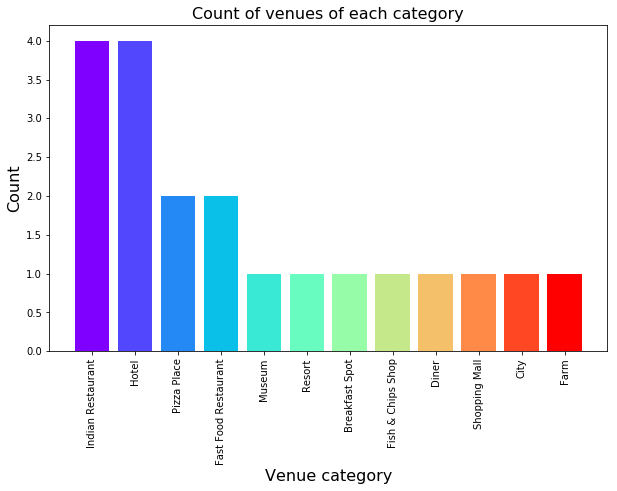

In [39]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (10, 6))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

It can be observed from bar-chart that except __Hotel__ and __Indian Restaurant__ are maximum in the data.

<a id='Rating'></a>
## Rating 

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place.

The ratings are plotted on the Bar-Plot to see the most common ratings.

C:\Users\sakshi aggarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Count of venues with given rating')

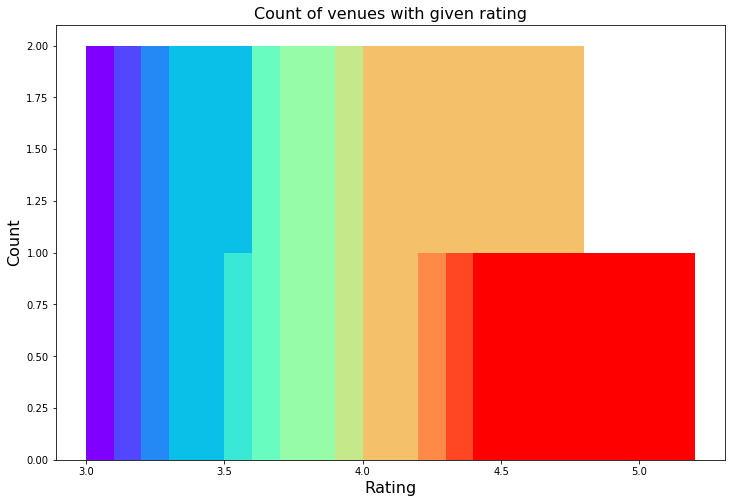

In [40]:
selected_venues['Rating'] = selected_venues['Rating'].astype(float)
rating = selected_venues['Rating'].value_counts().sort_index()
plt.figure(figsize = (12, 8))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot it is clear that majority venues have a rating between 3.0 to 4.5. 

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2
- 2 to 3
- 3 to 4
- 4 to 5

In [41]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very Good']
selected_venues['Rating_bin'] = pd.cut(selected_venues['Rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

C:\Users\sakshi aggarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
selected_venues

,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,City,Punjab Dhaba,31.6284,74.8767,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",450.0,Good
1,Breakfast Spot,Kanha Sweets,31.6461,74.8780,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",75.0,Very Good
2,Indian Restaurant,Kesar Da Dhaba,31.6244,74.8730,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",250.0,Very Good
3,Indian Restaurant,Crystal Restaurant Plaza,31.6355,74.8759,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",250.0,Good
4,Indian Restaurant,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",100.0,Very Good
5,Resort,Buzz - Hotel Golden Tulip,31.6340,74.8600,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",500.0,Good
6,Hotel,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",700.0,Good
7,Fast Food Restaurant,The Kulcha Land,31.6532,74.8639,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",100.0,Very Good
8,Museum,Mirch Masala Punjabi Dhaba,31.6215,74.8797,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",100.0,Good
9,Hotel,Scotch Haus - Hyatt Regency Amritsar,31.6186,74.9087,4.0,3.6,"Hyatt Regency, MBM Farms, GT Road, Amritsar",750.0,Good


Now, we will plot the venues on map.

In [43]:
color_map = {'Low': 'darkgreen', 'Okay': 'green', 'Good': 'orange', 'Very Good': 'red'}

amritsar_map = folium.Map(location = [amr_latitude, amr_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['Venue'], 
                                                          selected_venues['Address'], 
                                                          selected_venues['Latitude'], 
                                                          selected_venues['Longitude'], 
                                                          selected_venues['Rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(amritsar_map)  

amritsar_map.save("Amritsarmap//Venues Ratings.html")
amritsar_map

The map has the location of all the venues available. It appears that many venues are located in __Joshi Nagar__ with rating above 4.0. If someone wants to explore new venues, they should definitely check out __Joshi Nagar__.

<a id='Price'></a>
## Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the Average cost per person and the other is Price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. __We'll size the points based on the price to highlight their price.__

Text(0.5,1,'Count of venues with given average price')

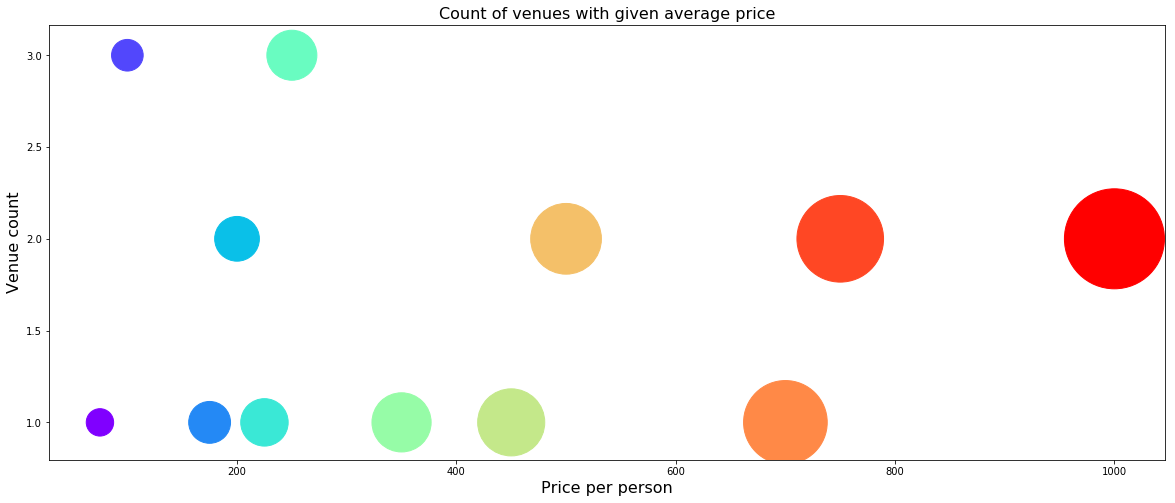

In [44]:
average_prices = selected_venues['Average Price per Person'].value_counts().sort_index()
plt.figure(figsize = (20, 8))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a most venues have an average price between Rs 200 and Rs 300.

We'll use the __Price_range column__ to plot the venues on a map.
Venues with __lower price range__ are represented with __green color__ and __high price range__ with __red color__.

In [45]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

amritsar_map = folium.Map(location = [amr_latitude, amr_longitude], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['Venue'], 
                                                           selected_venues['Address'], 
                                                           selected_venues['Latitude'], 
                                                           selected_venues['Longitude'], 
                                                           selected_venues['Price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(amritsar_map)  

amritsar_map.save("Amritsarmap//Venues Prices.html")
amritsar_map

__Observation from map :__
Venues with good ratings are located in Joshi Nagar.

<a id='Clustering'></a>
## Clustering

We will now cluster all these venues based on their Price range, Location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [46]:
NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['Venue', 'Address', 'Rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)

In [47]:
selected_venues

,cluster_labels,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,1,City,Punjab Dhaba,31.6284,74.8767,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",450.0,Good
1,1,Breakfast Spot,Kanha Sweets,31.6461,74.8780,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",75.0,Very Good
2,1,Indian Restaurant,Kesar Da Dhaba,31.6244,74.8730,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",250.0,Very Good
3,1,Indian Restaurant,Crystal Restaurant Plaza,31.6355,74.8759,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",250.0,Good
4,1,Indian Restaurant,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",100.0,Very Good
5,1,Resort,Buzz - Hotel Golden Tulip,31.6340,74.8600,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",500.0,Good
6,0,Hotel,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",700.0,Good
7,1,Fast Food Restaurant,The Kulcha Land,31.6532,74.8639,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",100.0,Very Good
8,1,Museum,Mirch Masala Punjabi Dhaba,31.6215,74.8797,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",100.0,Good
9,0,Hotel,Scotch Haus - Hyatt Regency Amritsar,31.6186,74.9087,4.0,3.6,"Hyatt Regency, MBM Farms, GT Road, Amritsar",750.0,Good


In [48]:
selected_venues['Rating'].mean()

4.0

Let's plot the clusters on the map.

In [49]:
amritsar_map = folium.Map(location = [amr_latitude, amr_longitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['Venue'], 
                                                        selected_venues['Address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['Latitude'], 
                                                        selected_venues['Longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(amritsar_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(amritsar_map)

amritsar_map.save("Amritsarmap//Venues Clusters.html")
amritsar_map

From the map, it can be observed that most venues fall under __Cluster 0__.

### Cluster 0 

In [50]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.reset_index(drop = True)

Cluster 0


,cluster_labels,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,0,Hotel,Cafe Mosaic - Country Inn & Suites,31.6353,74.8735,3.0,3.4,"Country Inn & Suites, Queens Road, INA Colony,...",700.0,Good
1,0,Hotel,Scotch Haus - Hyatt Regency Amritsar,31.6186,74.9087,4.0,3.6,"Hyatt Regency, MBM Farms, GT Road, Amritsar",750.0,Good
2,0,Farm,Proof - Radisson Blu,31.7058,74.8189,4.0,3.5,"Ajnala Road, State Highway 25, Opposite Intern...",1000.0,Good
3,0,Hotel,Proof - Radisson Blu,31.7058,74.8189,4.0,3.5,"Ajnala Road, State Highway 25, Opposite Intern...",1000.0,Good
4,0,Hotel,Al Fresco - Ramada,31.6280,74.8774,4.0,4.0,"117/1, Hall bazar, Town Hall, Amritsar",750.0,Good


In [51]:
print("These venues for cluster 0 have Average price per person of {:.02f} and rating spread around {:.02f}".
      format(result['Average Price per Person'].mean(), result['Rating'].astype(float).mean()))

These venues for cluster 0 have Average price per person of 840.00 and rating spread around 3.60


### Cluster 1 

In [52]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.reset_index(drop = True)

Cluster 1


,cluster_labels,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,1,City,Punjab Dhaba,31.6284,74.8767,3.0,4.0,"Chowk Gol Hatti,Opposite Yes Bank, Town Hall, ...",450.0,Good
1,1,Breakfast Spot,Kanha Sweets,31.6461,74.8780,1.0,4.8,"Shop 1, Opposite Bijli Pehalwan Mandir, Lawren...",75.0,Very Good
2,1,Indian Restaurant,Kesar Da Dhaba,31.6244,74.8730,2.0,4.7,"Near Telephone Exchange, Chowk Passian, Hathi ...",250.0,Very Good
3,1,Indian Restaurant,Crystal Restaurant Plaza,31.6355,74.8759,2.0,3.7,"1st and 2nd Floor, Crystal Chowk, Queens Road,...",250.0,Good
4,1,Indian Restaurant,Bhai Kulwant Singh Kulchian Wale,31.6214,74.8785,1.0,4.6,"Bazar Bikaneria, Near Golden Temple, Katra Ahl...",100.0,Very Good
5,1,Resort,Buzz - Hotel Golden Tulip,31.6340,74.8600,3.0,3.6,"Golden Tulip, 8, GT Road, Model Town, Rani Ka ...",500.0,Good
6,1,Fast Food Restaurant,The Kulcha Land,31.6532,74.8639,1.0,4.4,"Opposite District Shopping Centre, Ranjit Aven...",100.0,Very Good
7,1,Museum,Mirch Masala Punjabi Dhaba,31.6215,74.8797,1.0,3.7,"Shop 6, Near Bazar Bagh, Jallianwala, Town Hal...",100.0,Good
8,1,Diner,Surjit Food Plaza,31.6423,74.8762,3.0,4.1,"Shop 4, Nehru Shopping Complex, Lawrence Road,...",500.0,Very Good
9,1,Pizza Place,Canadian Pizza,31.6309,74.8742,2.0,3.9,"Shop 13 I/S, Hall Gate Hathi Gate, Amritsar",175.0,Good


In [53]:
print("These venues for cluster 1 have Average price per person of {:.02f} and rating spread around {:.02f}".
      format(result['Average Price per Person'].mean(), result['Rating'].astype(float).mean()))

These venues for cluster 1 have Average price per person of 248.33 and rating spread around 4.13


<a id='Results'></a>
## Results

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting __Amritsar, India__.

After collecting data from the __Foursquare and Zomato APIs__, we got a list of __47 different venues__. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of __20__.

We identified that from the total set of venues, majority of them were __Hotel and Indian Restaurant__ categories.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there is cluster of venues around __Joshi Nagar__. The cluster also have high rating (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of __Rs 200 to Rs 300__ for one person. Also , it's been observed that Joshi Nagar seems to have average to high priced venues.

Finally, through __cluster 1__ we identified that there are many venues which are relatively lower priced but have an average rating of __4.13__ which is certainly high.And through __cluster 0__ it has been identified that there are many venues which are high priced but have an average rating of __3.60__ which is low.

 __So, If you're looking for cheap places with relatively high rating, you should check Joshi Nagar.__

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

<a id='Conclusion'></a>
## Conclusion

The purpose of this project was to explore the places that a person visiting Amritsar could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that the major area in Amritsar to visit is Joshi Nagar. Based on the visitor's venue rating and price requirements, he/she can choose places.